## Testing the relationship between $\mu$ or $\alpha$ and the amplitudes 

One can think of fitting a model of spheroidal harmonics to a particular spherical mode as fitting to a projection of the overall GW. 

First, we fix a start time that minimises the mismatch. 

Fit $[(2,2,0,1), (3,3,0,1)]$ to $(2,2)$, $[(2,2,0,1), (3,3,0,1)]$ to $(3,3)$ etc. 

We obtain amplitudes $A^{22}_{220+}$, $A^{22}_{330+}$, $A^{33}_{220+}$, $A^{33}_{330+}$ etc.

Then, if we fit a combined model $[(2,2,0,1), (3,3,0,1)]$ to $[(2,2), (3,3)]$, we will obtain different amplitudes $A_{220+}$, $A_{330+}$. 

### Claim: 

$A^{22}_{220+}=\mu_{2220}A_{220+}$, 

$A^{33}_{330+} = \mu_{3330}A_{330+}$ etc. 

Similarly, we should expect this to happen for quadratic modes. This provides a test of the $\alpha$ coefficients. 



In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from qnmfitsrd.qnm import qnm
qnm = qnm()

import qnmfitsrd as qnmfits

sim = qnmfits.SXS(ID=305, zero_time=(2,2))

Mf=sim.Mf
chif=sim.chif_mag

Found the following files to load from the SXS catalog:
    SXS:BBH:0305v5/Lev6/metadata.json
Found the following files to load from the SXS catalog:
    SXS:BBH:0305v5/Lev6/rhOverM_Asymptotic_GeometricUnits_CoM.h5


#### Choose a start time

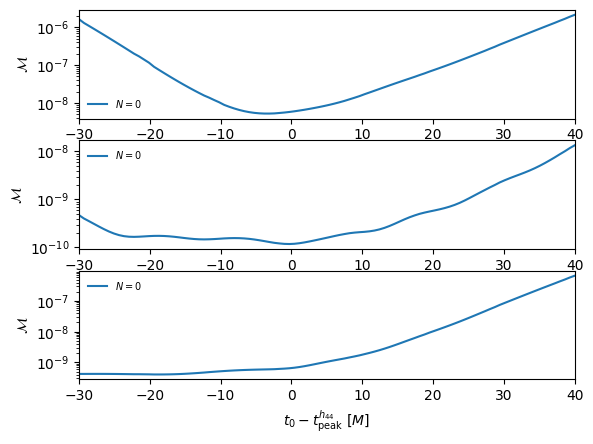

In [4]:
modes = [(l,m,0,1) for l in range(2,9) for m in range(-l,l+1)] 

t0_array = np.linspace(-30, 40, 100)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, dpi=100)

mm_list_22 = qnmfits.mismatch_t0_array(
    sim.times,
    sim.h[2,2],
    modes,
    Mf=sim.Mf,
    chif=sim.chif_mag,
    t0_array=t0_array
)

ax1.semilogy(t0_array, mm_list_22, label=f'$N = {modes[-1][-2]}$')
ax1.set_xlim(t0_array[0], t0_array[-1])
ax1.set_xlabel('$t_0 - t^{h_{22}}_\mathrm{peak}\ [M]$')
ax1.set_ylabel('$\mathcal{M}$')
ax1.legend(ncol=2, frameon=False, fontsize=7)

mm_list_33 = qnmfits.mismatch_t0_array(
    sim.times,
    sim.h[3,3],
    modes,
    Mf=sim.Mf,
    chif=sim.chif_mag,
    t0_array=t0_array
)

ax2.semilogy(t0_array, mm_list_33, label=f'$N = {modes[-1][-2]}$')
ax2.set_xlim(t0_array[0], t0_array[-1])
ax2.set_xlabel('$t_0 - t^{h_{33}}_\mathrm{peak}\ [M]$')
ax2.set_ylabel('$\mathcal{M}$')
ax2.legend(ncol=2, frameon=False, fontsize=7)

mm_list_44 = qnmfits.mismatch_t0_array(
    sim.times,
    sim.h[4,4],
    modes,
    Mf=sim.Mf,
    chif=sim.chif_mag,
    t0_array=t0_array
)

ax3.semilogy(t0_array, mm_list_44, label=f'$N = {modes[-1][-2]}$')
ax3.set_xlim(t0_array[0], t0_array[-1])
ax3.set_xlabel('$t_0 - t^{h_{44}}_\mathrm{peak}\ [M]$')
ax3.set_ylabel('$\mathcal{M}$')
ax3.legend(ncol=2, frameon=False, fontsize=7)

#### Calculate amplitudes when fitting the model to individual spherical modes

         (2, 0, 0, 1)  (2, 0, 1, 1)  (2, 0, 2, 1)  (2, 0, 3, 1)  (2, 0, 4, 1)  \
(2, -2)           NaN           NaN           NaN           NaN           NaN   
(2, -1)           NaN           NaN           NaN           NaN           NaN   
(2, 0)   2.322550e+02  2.353573e+06  5.464211e+07  1.067958e+08  1.397711e+08   
(2, 1)            NaN           NaN           NaN           NaN           NaN   
(2, 2)            NaN           NaN           NaN           NaN           NaN   
(3, -3)           NaN           NaN           NaN           NaN           NaN   
(3, -2)           NaN           NaN           NaN           NaN           NaN   
(3, -1)           NaN           NaN           NaN           NaN           NaN   
(3, 0)   3.286732e+02  2.970798e+06  5.492023e+07  8.320296e+07  8.670917e+07   
(3, 1)            NaN           NaN           NaN           NaN           NaN   
(3, 2)            NaN           NaN           NaN           NaN           NaN   
(3, 3)            NaN       

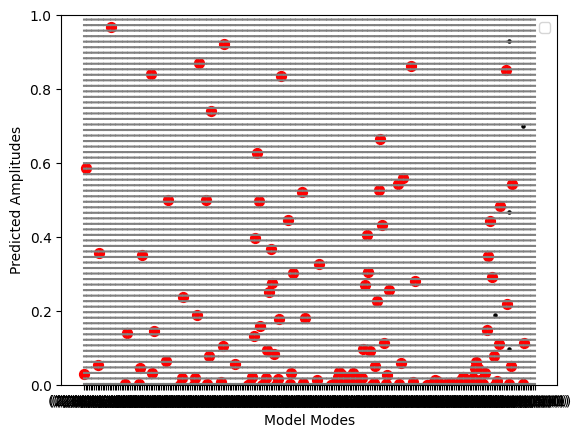

In [133]:
model_modes = [(l,m,n,1) for l in range(2,8) for m in range(0,l+1) for n in range(0,8)] 
spherical_modes = list(sim.h.keys())

#model_modes = [(2,2,0,1), (3,2,0,1), (4,4,0,1)]
#spherical_modes = [(3,3), (4,4), (3,2)]

# Determine the partial amplitudes for each spherical mode 

partial_amplitudes = pd.DataFrame(columns=spherical_modes, index=model_modes) 

for spherical_mode in spherical_modes:
    best_fit = qnmfits.ringdown_fit(
        sim.times,
        sim.h[spherical_mode],
        model_modes,
        Mf=sim.Mf,
        chif=sim.chif_mag,
        t0=0
    )
    partial_amplitudes[spherical_mode] = best_fit['C']

# Determine the full amplitudes for the overall model (with all spherical modes included)

amplitudes = pd.DataFrame(columns=['All'], index=model_modes) 

best_fit = qnmfits.multimode_ringdown_fit(
    sim.times,
    sim.h,
    model_modes,
    Mf=sim.Mf,
    chif=sim.chif_mag,
    t0=0
)

amplitudes['All'] = abs(best_fit['C'])

# Calculate a matrix of mixing coefficients

indices_lists = [[lm_mode+mode for mode in model_modes] for lm_mode in spherical_modes]
mu_lists = [qnm.mu_list(indices, chif) for indices in indices_lists]
mus = pd.DataFrame(mu_lists, columns=model_modes, index=spherical_modes).T

predicted_amplitudes = abs(partial_amplitudes / mus).T
predicted_amplitudes = predicted_amplitudes.replace([np.inf, -np.inf], np.nan)
predicted_amplitudes_long = predicted_amplitudes.reset_index().melt(id_vars='index', var_name='model_mode', value_name='value')
predicted_amplitudes_long['model_mode'] = predicted_amplitudes_long['model_mode'].astype(str)

plt.scatter(
    x=predicted_amplitudes_long['model_mode'], 
    y=predicted_amplitudes_long['value'],
    s=5,
    color='black',
)

plt.scatter(
    amplitudes.index.astype(str),
    amplitudes['All'],
    s=50,
    color='red',
)

for x_label in predicted_amplitudes_long['model_mode'].unique():
    plt.axvline(x=x_label, linestyle='dotted', color='gray')

plt.xlabel('Model Modes')
plt.ylabel('Predicted Amplitudes')

plt.ylim(0, 1)
plt.legend()
plt.show()